In [1]:
# !pip install -q tfds-nightly

# # Pin matplotlib version to 3.2.2 since in the latest version
# # transformer.ipynb fails with the following error:
# # https://stackoverflow.com/questions/62953704/valueerror-the-number-of-fixedlocator-locations-5-usually-from-a-call-to-set
# !pip install matplotlib==3.2.2

In [2]:
#import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [3]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [4]:
# Download the file
path_to_file = "rus-eng\\rus.txt"

In [5]:
def preprocess_sentence(w):
  w = w.lower().strip()

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [6]:
preprocess_sentence("I can't go.")

"<start> i can't go . <end>"

In [7]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENG, RUS]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [8]:
en, ru = create_dataset(path_to_file, None)
print(en[-1])
print(ru[-1])

<start> doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> несомненно , для каждого мужчины в этом мире где то есть подходящая женщина , которая может стать ему женой , обратное верно и для женщин . но если учесть , что у человека может быть максимум несколько сотен знакомых , из которых лишь дюжина , а то и меньше , тех , кого он знает близко , а из этой дюжины у него один или от силы два друга , то можно легко увидеть , что с уч том миллионов живущих на земле людей , ни один подходящи

In [9]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [10]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [11]:
# Try experimenting with the size of that dataset
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [12]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


In [13]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [14]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
12 ----> вы
7 ----> не
4 ----> я
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
29 ----> you're
32 ----> not
14 ----> me
3 ----> .
2 ----> <end>


In [15]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 128
units = 512

vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [17]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 15]), TensorShape([64, 11]))

In [24]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [25]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


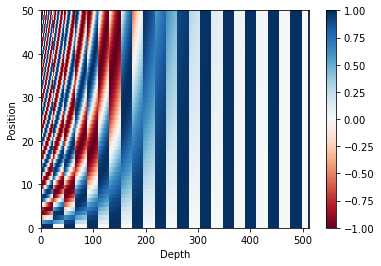

In [26]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

Замаскируйте все маркеры площадок в пакете последовательности. Это гарантирует, что модель не обрабатывает отступы как входные данные. Маска указывает, где присутствует значение пэда 0 : она выводит 1 в этих местах и 0 противном случае.

In [27]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [28]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

Маска упреждающего просмотра используется для маскировки будущих токенов в последовательности. Другими словами, маска указывает, какие записи не следует использовать.

Это означает, что для предсказания третьего слова будут использоваться только первое и второе слово. Аналогично для предсказания четвертого слова будут использоваться только первое, второе и третье слово и так далее.



In [29]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [30]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

Функция внимания, используемая преобразователем, принимает три входа: Q (запрос), K (ключ), V (значение). Уравнение, используемое для расчета весов внимания:


$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

Внимание скалярного произведения масштабируется с коэффициентом квадратного корня из глубины. Это сделано потому, что для больших значений глубины скалярное произведение увеличивается по величине, подталкивая функцию softmax, где у него есть небольшие градиенты, что приводит к очень жесткому softmax.

Например, предположим, что Q и K имеют среднее значение 0 и дисперсию 1. Их матричное умножение будет иметь среднее значение 0 и дисперсию dk . Следовательно, для масштабирования используется квадратный корень из dk (а не какое-либо другое число), потому что матрица Q и K должна иметь среднее значение 0 и дисперсию 1, и вы получите более мягкий softmax.

Маска умножается на -1e9 (близко к отрицательной бесконечности). Это сделано потому, что маска суммируется с умножением масштабированной матрицы Q и K и применяется непосредственно перед softmax. Цель состоит в том, чтобы обнулить эти ячейки, и большие отрицательные входные данные для softmax близки к нулю на выходе.



In [31]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

Поскольку нормализация softmax выполняется для K, его значения определяют степень важности, придаваемой Q.

Выходные данные представляют собой умножение весов внимания и вектора V (значения). Это гарантирует, что слова, на которых вы хотите сосредоточиться, останутся как есть, а нерелевантные слова будут удалены.



In [32]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [33]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [34]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [35]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Pass all the queries together.

In [36]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Многоголовое внимание состоит из четырех частей:

* Слои линейные и разбиваются на головы.
* Повышенное внимание к скалярному продукту
* Конкатенация голов.
* Финальный линейный слой.

Каждый блок внимания с несколькими головами получает три входа; Q (запрос), K (ключ), V (значение). Они проходят через линейные (плотные) слои и разбиваются на несколько головок.

scaled_dot_product_attention определенный выше, применяется к каждой голове (транслируется для эффективности). На этапе внимания необходимо использовать соответствующую маску. Затем вывод внимания для каждой головы объединяется (с использованием tf.transpose и tf.reshape ) и пропускается через последний слой Dense .

Вместо одной единственной головы внимания Q, K и V разделены на несколько голов, потому что это позволяет модели совместно обращать внимание на информацию в разных положениях из разных пространств представления. После разделения каждая голова имеет уменьшенную размерность, поэтому общая стоимость вычислений такая же, как и внимание одной головы с полной размерностью.



In [37]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

Создайте слой MultiHeadAttention чтобы попробовать. В каждом месте в последовательности y MultiHeadAttention запускает все 8 головок внимания по всем другим местам в последовательности, возвращая новый вектор той же длины в каждом месте.



In [38]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network

Сеть с точечной прямой связью состоит из двух полностью связанных слоев с активацией ReLU между ними.


In [39]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [40]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

Модель трансформера следует той же общей схеме, что и стандартная последовательность действий с моделью внимания .

Входное предложение проходит через N уровней кодировщика, которые генерируют выходные данные для каждого слова / токена в последовательности.
Декодер отслеживает вывод кодировщика и свой собственный ввод (самовнимание), чтобы предсказать следующее слово.


### Encoder layer

Каждый уровень кодировщика состоит из подслоев:

Многоголовое внимание (с дополнительной маской)
Точечные сети прямого распространения.
Каждый из этих подуровней имеет остаточную связь вокруг себя, за которой следует нормализация уровня. Остаточные соединения помогают избежать проблемы исчезающего градиента в глубоких сетях.

Результатом каждого подслоя является LayerNorm(x + Sublayer(x)) . Нормализация выполняется по d_model (последняя). В трансформаторе N слоев кодировщика.



In [41]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [42]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer

Каждый слой декодера состоит из подслоев:

Замаскированное внимание с несколькими головами (с опережающей маской и дополнительной маской)
Многоголовое внимание (с дополнительной маской). V (значение) и K (ключ) получают выходной сигнал энкодера в качестве входных данных. Q (запрос) получает выходные данные от подуровня замаскированного многоголового внимания.
Точечные сети прямого распространения
Каждый из этих подуровней имеет остаточную связь вокруг себя, за которой следует нормализация уровня. Результатом каждого подслоя является LayerNorm(x + Sublayer(x)) . Нормализация выполняется по d_model (последняя).

В трансформаторе N слоев декодера.

Поскольку Q принимает выходные данные от первого блока внимания декодера, а K принимает выходные данные кодировщика, веса внимания представляют важность, придаваемую входу декодера на основе выходных данных кодера. Другими словами, декодер предсказывает следующее слово, глядя на выходные данные кодировщика и самостоятельно присматриваясь к своим собственным выходным данным. См. Демонстрацию выше в разделе «Внимание к скалярному произведению».



In [43]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [44]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [45]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [46]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [47]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [48]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [49]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [50]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [51]:
# inp_lang, targ_lang 

In [52]:
len(inp_lang.word_index)

20206

In [53]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

steps_per_epoch = len(input_tensor_train)//BATCH_SIZE

input_vocab_size = len(inp_lang.word_index) + 2
target_vocab_size = len(targ_lang.word_index) + 2
dropout_rate = 0.1

In [54]:
target_vocab_size

7149

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [55]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [56]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

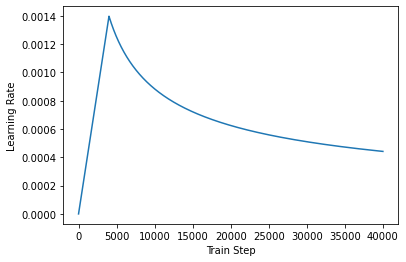

In [57]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [58]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [59]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))
  
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [60]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
# train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## Training and checkpointing

In [61]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [62]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [63]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Цель делится на tar_inp и tar_real. tar_inp передается декодеру в качестве входных данных. tar_real - это тот же самый ввод, сдвинутый на 1: в каждом месте tar_input tar_real содержит следующий токен, который должен быть предсказан.

Например, sentence = "SOS Лев в джунглях спит EOS"

tar_inp = "SOS tar_inp лев в джунглях"

tar_real = "Лев в джунглях спит EOS"

Преобразователь - это авторегрессивная модель: он делает прогнозы по частям и использует свои выходные данные, чтобы решить, что делать дальше.

Во время обучения в этом примере используется принуждение учителя (как в учебнике по созданию текста ). Принуждение учителя передает истинный результат следующему временному шагу независимо от того, что модель предсказывает на текущем временном шаге.

Поскольку преобразователь предсказывает каждое слово, самовнимание позволяет ему смотреть на предыдущие слова во входной последовательности, чтобы лучше предсказать следующее слово.

Чтобы модель не просматривала ожидаемый результат, в модели используется маска просмотра вперед.



In [64]:
EPOCHS = 50

In [65]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [66]:
#inp.shape, tar.shape

Ru is used as the input language and English is the target language.

In [68]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(dataset.take(steps_per_epoch)):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 8.8735 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.7565 Accuracy 0.0318
Epoch 1 Batch 100 Loss 8.5803 Accuracy 0.0653
Epoch 1 Batch 150 Loss 8.4105 Accuracy 0.0774
Epoch 1 Batch 200 Loss 8.2155 Accuracy 0.0849
Epoch 1 Batch 250 Loss 7.9783 Accuracy 0.1028
Epoch 1 Batch 300 Loss 7.7102 Accuracy 0.1160
Epoch 1 Batch 350 Loss 7.4278 Accuracy 0.1255
Epoch 1 Batch 400 Loss 7.1507 Accuracy 0.1331
Epoch 1 Batch 450 Loss 6.8870 Accuracy 0.1417
Epoch 1 Batch 500 Loss 6.6449 Accuracy 0.1505
Epoch 1 Batch 550 Loss 6.4220 Accuracy 0.1585
Epoch 1 Batch 600 Loss 6.2172 Accuracy 0.1659
Epoch 1 Batch 650 Loss 6.0309 Accuracy 0.1724
Epoch 1 Batch 700 Loss 5.8609 Accuracy 0.1784
Epoch 1 Batch 750 Loss 5.7047 Accuracy 0.1840
Epoch 1 Batch 800 Loss 5.5615 Accuracy 0.1893
Epoch 1 Batch 850 Loss 5.4288 Accuracy 0.1944
Epoch 1 Batch 900 Loss 5.3074 Accuracy 0.1991
Epoch 1 Batch 950 Loss 5.1945 Accuracy 0.2036
Epoch 1 Batch 1000 Loss 5.0883 Accuracy 0.2079
Epoch 1 Batch 1050 Loss 4.9891 Accur

Epoch 7 Batch 800 Loss 0.7532 Accuracy 0.4913
Epoch 7 Batch 850 Loss 0.7550 Accuracy 0.4912
Epoch 7 Batch 900 Loss 0.7550 Accuracy 0.4914
Epoch 7 Batch 950 Loss 0.7575 Accuracy 0.4912
Epoch 7 Batch 1000 Loss 0.7576 Accuracy 0.4914
Epoch 7 Batch 1050 Loss 0.7586 Accuracy 0.4913
Epoch 7 Batch 1100 Loss 0.7588 Accuracy 0.4912
Epoch 7 Batch 1150 Loss 0.7592 Accuracy 0.4912
Epoch 7 Batch 1200 Loss 0.7591 Accuracy 0.4914
Epoch 7 Loss 0.7597 Accuracy 0.4914
Time taken for 1 epoch: 103.4976909160614 secs

Epoch 8 Batch 0 Loss 0.7509 Accuracy 0.4969
Epoch 8 Batch 50 Loss 0.6395 Accuracy 0.5027
Epoch 8 Batch 100 Loss 0.6371 Accuracy 0.5033
Epoch 8 Batch 150 Loss 0.6518 Accuracy 0.5010
Epoch 8 Batch 200 Loss 0.6537 Accuracy 0.5006
Epoch 8 Batch 250 Loss 0.6578 Accuracy 0.5006
Epoch 8 Batch 300 Loss 0.6621 Accuracy 0.5006
Epoch 8 Batch 350 Loss 0.6654 Accuracy 0.5005
Epoch 8 Batch 400 Loss 0.6651 Accuracy 0.5000
Epoch 8 Batch 450 Loss 0.6682 Accuracy 0.4999
Epoch 8 Batch 500 Loss 0.6720 Accuracy 0

Epoch 14 Batch 150 Loss 0.4582 Accuracy 0.5237
Epoch 14 Batch 200 Loss 0.4646 Accuracy 0.5229
Epoch 14 Batch 250 Loss 0.4652 Accuracy 0.5232
Epoch 14 Batch 300 Loss 0.4686 Accuracy 0.5231
Epoch 14 Batch 350 Loss 0.4708 Accuracy 0.5230
Epoch 14 Batch 400 Loss 0.4750 Accuracy 0.5227
Epoch 14 Batch 450 Loss 0.4782 Accuracy 0.5227
Epoch 14 Batch 500 Loss 0.4838 Accuracy 0.5224
Epoch 14 Batch 550 Loss 0.4863 Accuracy 0.5222
Epoch 14 Batch 600 Loss 0.4874 Accuracy 0.5220
Epoch 14 Batch 650 Loss 0.4906 Accuracy 0.5217
Epoch 14 Batch 700 Loss 0.4920 Accuracy 0.5217
Epoch 14 Batch 750 Loss 0.4935 Accuracy 0.5214
Epoch 14 Batch 800 Loss 0.4968 Accuracy 0.5212
Epoch 14 Batch 850 Loss 0.5000 Accuracy 0.5209
Epoch 14 Batch 900 Loss 0.5027 Accuracy 0.5206
Epoch 14 Batch 950 Loss 0.5036 Accuracy 0.5206
Epoch 14 Batch 1000 Loss 0.5053 Accuracy 0.5204
Epoch 14 Batch 1050 Loss 0.5068 Accuracy 0.5203
Epoch 14 Batch 1100 Loss 0.5083 Accuracy 0.5202
Epoch 14 Batch 1150 Loss 0.5096 Accuracy 0.5201
Epoch 14 

Epoch 20 Batch 750 Loss 0.4235 Accuracy 0.5308
Epoch 20 Batch 800 Loss 0.4250 Accuracy 0.5305
Epoch 20 Batch 850 Loss 0.4279 Accuracy 0.5303
Epoch 20 Batch 900 Loss 0.4284 Accuracy 0.5303
Epoch 20 Batch 950 Loss 0.4300 Accuracy 0.5302
Epoch 20 Batch 1000 Loss 0.4311 Accuracy 0.5300
Epoch 20 Batch 1050 Loss 0.4336 Accuracy 0.5298
Epoch 20 Batch 1100 Loss 0.4355 Accuracy 0.5298
Epoch 20 Batch 1150 Loss 0.4363 Accuracy 0.5297
Epoch 20 Batch 1200 Loss 0.4381 Accuracy 0.5295
Saving checkpoint for epoch 20 at ./checkpoints/train\ckpt-4
Epoch 20 Loss 0.4391 Accuracy 0.5294
Time taken for 1 epoch: 103.69314312934875 secs

Epoch 21 Batch 0 Loss 0.4017 Accuracy 0.5328
Epoch 21 Batch 50 Loss 0.4022 Accuracy 0.5341
Epoch 21 Batch 100 Loss 0.3921 Accuracy 0.5338
Epoch 21 Batch 150 Loss 0.3881 Accuracy 0.5343
Epoch 21 Batch 200 Loss 0.3912 Accuracy 0.5338
Epoch 21 Batch 250 Loss 0.3951 Accuracy 0.5338
Epoch 21 Batch 300 Loss 0.3984 Accuracy 0.5335
Epoch 21 Batch 350 Loss 0.4032 Accuracy 0.5326
Epoch

Epoch 27 Batch 50 Loss 0.3377 Accuracy 0.5415
Epoch 27 Batch 100 Loss 0.3447 Accuracy 0.5401
Epoch 27 Batch 150 Loss 0.3495 Accuracy 0.5394
Epoch 27 Batch 200 Loss 0.3491 Accuracy 0.5398
Epoch 27 Batch 250 Loss 0.3513 Accuracy 0.5396
Epoch 27 Batch 300 Loss 0.3553 Accuracy 0.5388
Epoch 27 Batch 350 Loss 0.3568 Accuracy 0.5385
Epoch 27 Batch 400 Loss 0.3600 Accuracy 0.5381
Epoch 27 Batch 450 Loss 0.3641 Accuracy 0.5380
Epoch 27 Batch 500 Loss 0.3657 Accuracy 0.5379
Epoch 27 Batch 550 Loss 0.3679 Accuracy 0.5375
Epoch 27 Batch 600 Loss 0.3706 Accuracy 0.5372
Epoch 27 Batch 650 Loss 0.3726 Accuracy 0.5369
Epoch 27 Batch 700 Loss 0.3744 Accuracy 0.5368
Epoch 27 Batch 750 Loss 0.3769 Accuracy 0.5366
Epoch 27 Batch 800 Loss 0.3794 Accuracy 0.5362
Epoch 27 Batch 850 Loss 0.3816 Accuracy 0.5362
Epoch 27 Batch 900 Loss 0.3817 Accuracy 0.5362
Epoch 27 Batch 950 Loss 0.3835 Accuracy 0.5361
Epoch 27 Batch 1000 Loss 0.3854 Accuracy 0.5359
Epoch 27 Batch 1050 Loss 0.3868 Accuracy 0.5357
Epoch 27 Bat

Epoch 33 Batch 650 Loss 0.3505 Accuracy 0.5394
Epoch 33 Batch 700 Loss 0.3509 Accuracy 0.5395
Epoch 33 Batch 750 Loss 0.3519 Accuracy 0.5397
Epoch 33 Batch 800 Loss 0.3535 Accuracy 0.5396
Epoch 33 Batch 850 Loss 0.3546 Accuracy 0.5396
Epoch 33 Batch 900 Loss 0.3566 Accuracy 0.5393
Epoch 33 Batch 950 Loss 0.3582 Accuracy 0.5392
Epoch 33 Batch 1000 Loss 0.3591 Accuracy 0.5391
Epoch 33 Batch 1050 Loss 0.3580 Accuracy 0.5392
Epoch 33 Batch 1100 Loss 0.3596 Accuracy 0.5391
Epoch 33 Batch 1150 Loss 0.3606 Accuracy 0.5391
Epoch 33 Batch 1200 Loss 0.3621 Accuracy 0.5389
Epoch 33 Loss 0.3639 Accuracy 0.5386
Time taken for 1 epoch: 103.15014004707336 secs

Epoch 34 Batch 0 Loss 0.4632 Accuracy 0.5266
Epoch 34 Batch 50 Loss 0.3215 Accuracy 0.5419
Epoch 34 Batch 100 Loss 0.3187 Accuracy 0.5423
Epoch 34 Batch 150 Loss 0.3285 Accuracy 0.5413
Epoch 34 Batch 200 Loss 0.3270 Accuracy 0.5415
Epoch 34 Batch 250 Loss 0.3227 Accuracy 0.5422
Epoch 34 Batch 300 Loss 0.3253 Accuracy 0.5424
Epoch 34 Batch 350 

Epoch 39 Loss 0.3482 Accuracy 0.5411
Time taken for 1 epoch: 103.07581353187561 secs

Epoch 40 Batch 0 Loss 0.3366 Accuracy 0.5406
Epoch 40 Batch 50 Loss 0.2926 Accuracy 0.5450
Epoch 40 Batch 100 Loss 0.3031 Accuracy 0.5449
Epoch 40 Batch 150 Loss 0.3046 Accuracy 0.5441
Epoch 40 Batch 200 Loss 0.3018 Accuracy 0.5453
Epoch 40 Batch 250 Loss 0.3057 Accuracy 0.5449
Epoch 40 Batch 300 Loss 0.3088 Accuracy 0.5443
Epoch 40 Batch 350 Loss 0.3137 Accuracy 0.5435
Epoch 40 Batch 400 Loss 0.3168 Accuracy 0.5435
Epoch 40 Batch 450 Loss 0.3171 Accuracy 0.5432
Epoch 40 Batch 500 Loss 0.3188 Accuracy 0.5430
Epoch 40 Batch 550 Loss 0.3203 Accuracy 0.5429
Epoch 40 Batch 600 Loss 0.3230 Accuracy 0.5430
Epoch 40 Batch 650 Loss 0.3245 Accuracy 0.5429
Epoch 40 Batch 700 Loss 0.3251 Accuracy 0.5431
Epoch 40 Batch 750 Loss 0.3266 Accuracy 0.5429
Epoch 40 Batch 800 Loss 0.3284 Accuracy 0.5428
Epoch 40 Batch 850 Loss 0.3305 Accuracy 0.5428
Epoch 40 Batch 900 Loss 0.3323 Accuracy 0.5427
Epoch 40 Batch 950 Loss 

Epoch 46 Batch 450 Loss 0.2973 Accuracy 0.5455
Epoch 46 Batch 500 Loss 0.2993 Accuracy 0.5453
Epoch 46 Batch 550 Loss 0.3002 Accuracy 0.5452
Epoch 46 Batch 600 Loss 0.3027 Accuracy 0.5452
Epoch 46 Batch 650 Loss 0.3058 Accuracy 0.5448
Epoch 46 Batch 700 Loss 0.3099 Accuracy 0.5446
Epoch 46 Batch 750 Loss 0.3128 Accuracy 0.5445
Epoch 46 Batch 800 Loss 0.3146 Accuracy 0.5445
Epoch 46 Batch 850 Loss 0.3168 Accuracy 0.5444
Epoch 46 Batch 900 Loss 0.3195 Accuracy 0.5442
Epoch 46 Batch 950 Loss 0.3209 Accuracy 0.5441
Epoch 46 Batch 1000 Loss 0.3236 Accuracy 0.5438
Epoch 46 Batch 1050 Loss 0.3253 Accuracy 0.5437
Epoch 46 Batch 1100 Loss 0.3266 Accuracy 0.5437
Epoch 46 Batch 1150 Loss 0.3273 Accuracy 0.5437
Epoch 46 Batch 1200 Loss 0.3285 Accuracy 0.5436
Epoch 46 Loss 0.3292 Accuracy 0.5435
Time taken for 1 epoch: 103.07547187805176 secs

Epoch 47 Batch 0 Loss 0.2421 Accuracy 0.5594
Epoch 47 Batch 50 Loss 0.2740 Accuracy 0.5502
Epoch 47 Batch 100 Loss 0.2742 Accuracy 0.5472
Epoch 47 Batch 150 

## Evaluate

Для оценки используются следующие шаги:

Закодируйте входное предложение с помощью русского токенизатора ( tokenizer_pt ). Кроме того, добавьте начальный и конечный токены, чтобы ввод был эквивалентен тому, с чем обучается модель. Это вход энкодера.
Вход декодера - это start token == tokenizer_en.vocab_size .
Рассчитайте маски заполнения и маски прогнозирования.
Затем decoder выводит прогнозы, глядя на encoder output и собственные выходные данные (самовнимание).
Выберите последнее слово и вычислите его argmax.
Конкатентируйте предсказанное слово на вход декодера при передаче его в декодер.
В этом подходе декодер предсказывает следующее слово на основе предсказанных им предыдущих слов.


In [83]:
targ_lang.word_index

{'<start>': 1,
 '<end>': 2,
 '.': 3,
 'i': 4,
 'tom': 5,
 '?': 6,
 'you': 7,
 'is': 8,
 'a': 9,
 'it': 10,
 'to': 11,
 'the': 12,
 "i'm": 13,
 'me': 14,
 'do': 15,
 'was': 16,
 'that': 17,
 'we': 18,
 'this': 19,
 "don't": 20,
 'my': 21,
 'are': 22,
 'your': 23,
 'have': 24,
 'did': 25,
 'can': 26,
 'he': 27,
 'go': 28,
 "you're": 29,
 "it's": 30,
 'like': 31,
 'not': 32,
 'be': 33,
 'know': 34,
 'in': 35,
 "i'll": 36,
 'what': 37,
 'here': 38,
 'they': 39,
 ',': 40,
 'need': 41,
 'want': 42,
 'on': 43,
 'how': 44,
 "can't": 45,
 'very': 46,
 'now': 47,
 'why': 48,
 'for': 49,
 'help': 50,
 'us': 51,
 'will': 52,
 'at': 53,
 'one': 54,
 '!': 55,
 'up': 56,
 'so': 57,
 'has': 58,
 'all': 59,
 "didn't": 60,
 'get': 61,
 'with': 62,
 'who': 63,
 'of': 64,
 "that's": 65,
 "we're": 66,
 'got': 67,
 'come': 68,
 'too': 69,
 "let's": 70,
 'no': 71,
 'just': 72,
 'there': 73,
 'she': 74,
 'see': 75,
 "tom's": 76,
 'please': 77,
 "won't": 78,
 'were': 79,
 "isn't": 80,
 "i've": 81,
 'look': 82,

In [103]:
def evaluate(inp_sentence):
  start_token = [1]#[targ_lang.vocab_size]
  end_token = [2] #[targ_lang.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
  sentence = preprocess_sentence(inp_sentence)
  inp_sentence = [inp_lang.word_index[i] for i in sentence.split(' ')]  
  
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [1]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(max_length_targ):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == targ_lang.word_index['<end>']:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [116]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = [targ_lang.word_index[i] for i in sentence.split(' ')] 
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        [inp_lang_tokenizer.word_index[i] for i in sentence.split(' ')], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([inp_lang.word_index([i]) for i in result 
                        if i < len(inp_lang.word_index)+1], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [125]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = ([targ_lang.index_word[i] for i in result.numpy()])  

  print_sentence = ' '.join(predicted_sentence[1:])

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(print_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [128]:
#translate('он собирается домой', plot=True)

In [134]:
translate('я не люблю когда ночью идет снег')

Input: я не люблю когда ночью идет снег теплая погода гораздо лучше
Predicted translation: i didn't like night .


In [143]:
translate('я стараюсь проводить время с друзьями')

Input: я стараюсь проводить время с друзьями
Predicted translation: i try for a walk with friends .
